# CBED- Thickness Calculator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, e, c, m_e
from scipy.stats import linregress
import itertools
from scipy.stats import t


#conda install -c conda-forge ipywidgets
import ipywidgets as widgets
from IPython.display import display

In [118]:

class Sickness:


        
    def __init__(self, iterator = 2, kV = 200, solid = 'Al', kikBand = (2,2,0)):
        self.materials = {'Al':0.40475e-9, 'Fantasite': 666e-10, 'Au': 1.} #Al taken from https://arxiv.org/ftp/arxiv/papers/2002/2002.01562.pdf
        
        
        self.d_kik = widgets.FloatText(
        value=0,
        description='Kikuchi Spacing:',
        disabled=False)
            
        self.theta1 = widgets.FloatText(
        value=0,
        description='Theta1:',
        disabled=False)

        self.theta2 = widgets.FloatText(
        value=0,
        description='Theta2:',
        disabled=False)

        self.theta3 = widgets.FloatText(
        value=0,
        description='Theta3:',
        disabled=False)

        self.theta4 = widgets.FloatText(
        value=0.0,
        description='Theta4:',
        disabled=False)
      
        self.kV = kV
        self.kikBand = kikBand
        self.solid = solid
        self.iterator = iterator
        
        
        self.slider = widgets.IntSlider(
        min=80,
        max=300,
        step=20,
        description='Voltage [kV]:',
        value=self.kV,
        orientation = 'horizontal')
        
        self.kik_band = widgets.Dropdown(
        options=[(2,0,0), (2,2,0), (2,2,2)],
        value=self.kikBand,
        description='Kikuchi Band:',
        disabled=False)
       
        self.material = widgets.Dropdown(
        options=list(self.materials),         
        value=self.solid,
        description='Material:',
        disabled=False)
        
        self.latticeParam = widgets.FloatText(
        value=self.materials[self.solid],
        description='Lattice Parameter [nm]:',
        disabled=False)
        
        self.kStop_slider = widgets.IntSlider(
        min=1,
        max=10,
        step=1,
        description='max. iterator',
        value=self.iterator,
        orientation = 'horizontal')
        
        self.fname = widgets.Text(
        placeholder='Parameter Filename',
        description='String:',
        disabled=False)

        self.overWrite= widgets.ToggleButtons(
        options=['No', 'Yes'],
        description='Overwrite',
        disabled=False,
        button_style='')# 'success', 'info', 'warning', 'danger' or '')
        
        self.button = widgets.Button(description='Calculate Sickness!')
        test.button.on_click(None)
        display(self.slider, self.kStop_slider, self.material,self.latticeParam, self.kik_band,self.fname,self.overWrite, self.d_kik,self.theta1, self.theta2, self.theta3, self.theta4, self.button)
        
        
    def get_wavelength(self):
    # https://www.jeol.co.jp/en/words/emterms/search_result.html?keyword=wavelength%20of%20electron
    # https://www.jeol.co.jp/en/words/emterms/search_result.html?keyword=relativistic%20correction
        acceleration_voltage = self.slider.value*10**3
        V_corrected = acceleration_voltage*(1+ (e)/(2*m_e*c**2)*acceleration_voltage)
        lambd = h/np.sqrt(2*m_e*e*V_corrected)
        return lambd

    def get_d_hkl(self):
        (h,k,l) = self.kik_band.value
        d_hkl= self.materials[self.solid]/np.sqrt(h**2+k**2+l**2)
        return d_hkl
    
    def make_theta_list(self):
        if self.theta4.value !=0.0:
            return [self.theta1.value,self.theta2.value,self.theta3.value,self.theta4.value]
        else:
            return [self.theta1.value,self.theta2.value,self.theta3.value]

    def make_si(self):
        wavelength = self.get_wavelength()
        d_hkl = self.get_d_hkl()
        d_kik = self.d_kik.value
        theta_list = self.make_theta_list()
        return np.array([(wavelength*theta)/(d_kik*d_hkl**2) for theta in theta_list])

    def get_thickness_plot(self):
        si_list=self.make_si()
        kStart=1
        kStop= self.kStop_slider.value
        d_exct_list = []
        t_error_list = []
        t_list = []
        r2_list = []

        #For easy plotting
        x_data = []
        y_data = []
        slope_data = []
        intercept_data = []
        std_yintercept = []


        for i in range(kStop):
            nk_list = np.arange(start=kStart, stop= len(si_list)+kStart, step=1) #creating the necessary n_k
            SIsquared_over_NKsquared= np.array([S**2/N**2 for (S,N) in zip(si_list,nk_list)]) #creating Yvalues
            ONE_over_NKsquared = np.array([1/N**2 for N in nk_list]) #creating Xvalues
            y_data.append(SIsquared_over_NKsquared)
            x_data.append(ONE_over_NKsquared)

            result= linregress(ONE_over_NKsquared, SIsquared_over_NKsquared) #Getting all the necessary Data
            slope_data.append(result.slope)
            intercept_data.append(result.intercept)


            std_yintercept.append(result.intercept_stderr)


            # Getting Extinction length and Thickness T
            d_exct_g = np.sqrt(np.abs(1/result.slope)) * 10**9 # in nm
            d_exct_list.append(d_exct_g)

            t = np.sqrt(1/result.intercept)*10**9 # in nm  
            t_list.append(t)

            t_error_list.append(np.sqrt(1/result.intercept_stderr)*10**9)
            r2_list.append(result.rvalue**2)
            kStart+=1


        ##########
        #Determening uncertainty (Christoph apparently called Jackknife method):
        possible_t=[]
        pairs = []
        for m in range(kStop):
            pairs.append([])

            for i in zip(x_data[m],y_data[m]):
                pairs[m].append(i)
        all_combinations=[]
        for j in range(len(pairs)):
            combinations = itertools.combinations(pairs[j],len(x_data[m])-1)
            all_combinations.append(combinations)


        for k in range(len(all_combinations)):
            possible_t.append([])
            for line in list(all_combinations[k]):
                line_x = []
                line_y = []
                for point in line:
                    line_x.append(point[0])
                    line_y.append(point[1])
                result= linregress(line_x, line_y)
                t = np.sqrt(1/result.intercept)*10**9 # in nm  
                possible_t[k].append(t)

        t_std= []
        for l in range(len(possible_t)):
            t_std.append(np.nanstd(possible_t[l]))


        ############
        #Plotting
        plt.rcParams.update({'font.size': 18})

        fig, ax = plt.subplots(1,kStop, figsize = (25,10))
        for i in range(kStop):
            ax[i].plot(x_data[i],intercept_data[i]+slope_data[i]*x_data[i],c='g',label = r'$R^2$: '+str(round(r2_list[i],3))+'\n'+r'$\xi$ [nm]: '+str(round(d_exct_list[i],1))+'\n Thickness [nm]: '+str(round(t_list[i],1))+r'$\pm$'+str(round(t_std[i],1)))
            ax[i].scatter(x_data[i],y_data[i], c= 'r')



        for a in ax:
            a.legend(loc= 'upper right', facecolor='bisque')
            a.set_xlabel(r'$\frac{1}{n_k^2}$')
            y_label= a.set_ylabel(r'$\frac{s_i^2}{n_k^2}$')
            y_label.set_rotation(0)
            a.set_yticklabels([])
            a.set_xticklabels([])
        plt.show()
    
    
    
    def compare_with_simulation_220(self):
        findClosest = lambda num,array:min(array,key=lambda x:abs(x-num))
        
        t_sim = [34.425,40.5,60.75,65,71,75,81,85,91,101.25,105,111,120,130.8,140.3,149.3,162.6]
        kik_sim= np.array([0.69212,0.69212,0.69212,316.87,316.87,151,0.69212,316.87,151,0.69212,151,151,151,51.2,51.2,51.2,51.2])
        theta1_sim =np.array([0.1589,0.1369,0.0859,35.98,30.99,13.5,0.0599,23.98,11.8,0.0409,8.2,6.5,6.1,1.42,1.0764,0.87225,0.3358])
        theta2_sim =np.array([0.3169,0.2759,0.1839,76.95,69.97,34.0,0.1379,57.95,26.1,0.1059,22.3,19.5,18.5,5.805,5.302,4.856,4.378])
        theta3_sim =np.array([0.4969,0.4159,0.2769,117.93,105.96,47.5,0.2089,88.93,39.3,0.1629,34.7,30.7,29.4,9.269,8.5409,8.049,7.372])
        frac1 =theta1_sim/kik_sim
        frac2 =theta2_sim/kik_sim
        frac3 =theta3_sim/kik_sim
        experimental= [self.theta1.value/self.d_kik.value,self.theta2.value/self.d_kik.value,self.theta3.value/self.d_kik.value]

        closestTheta1=findClosest(experimental[0],frac1)
        closestTheta2=findClosest(experimental[1],frac2)
        closestTheta3=findClosest(experimental[2],frac3)
        
        closest_thick1 = t_sim[list(frac1).index(closestTheta1)]
        closest_thick2 = t_sim[list(frac2).index(closestTheta2)]
        closest_thick3 = t_sim[list(frac3).index(closestTheta3)]
        print('Experimental \u03B8 values are closest to the following thicknesses from simulation: {} nm,{} nm, {} nm.'.format(closest_thick1,closest_thick2,closest_thick3))
    
    def calculate_Sickness(self):
        pass
    def calculate_uncertainty(self):
        pass
    def Kelly_plots(self):
        pass
    def write_parameter_file(fname, params, overwrite):
        pass
    

    
    


test=Sickness(kV=200, kikBand=(2,2,0),solid='Al', iterator=2 )

IntSlider(value=200, description='Voltage [kV]:', max=300, min=80, step=20)

IntSlider(value=2, description='max. iterator', max=10, min=1)

Dropdown(description='Material:', options=('Al', 'Fantasite', 'Au'), value='Al')

FloatText(value=4.0475e-10, description='Lattice Parameter [nm]:')

Dropdown(description='Kikuchi Band:', index=1, options=((2, 0, 0), (2, 2, 0), (2, 2, 2)), value=(2, 2, 0))

Text(value='', description='String:', placeholder='Parameter Filename')

ToggleButtons(description='Overwrite', options=('No', 'Yes'), value='No')

FloatText(value=0.0, description='Kikuchi Spacing:')

FloatText(value=0.0, description='Theta1:')

FloatText(value=0.0, description='Theta2:')

FloatText(value=0.0, description='Theta3:')

FloatText(value=0.0, description='Theta4:')

Button(description='Calculate Sickness!', style=ButtonStyle())

# Type in your values above and execute the cell below
If only 3 minima are used, keep Theta4=0!

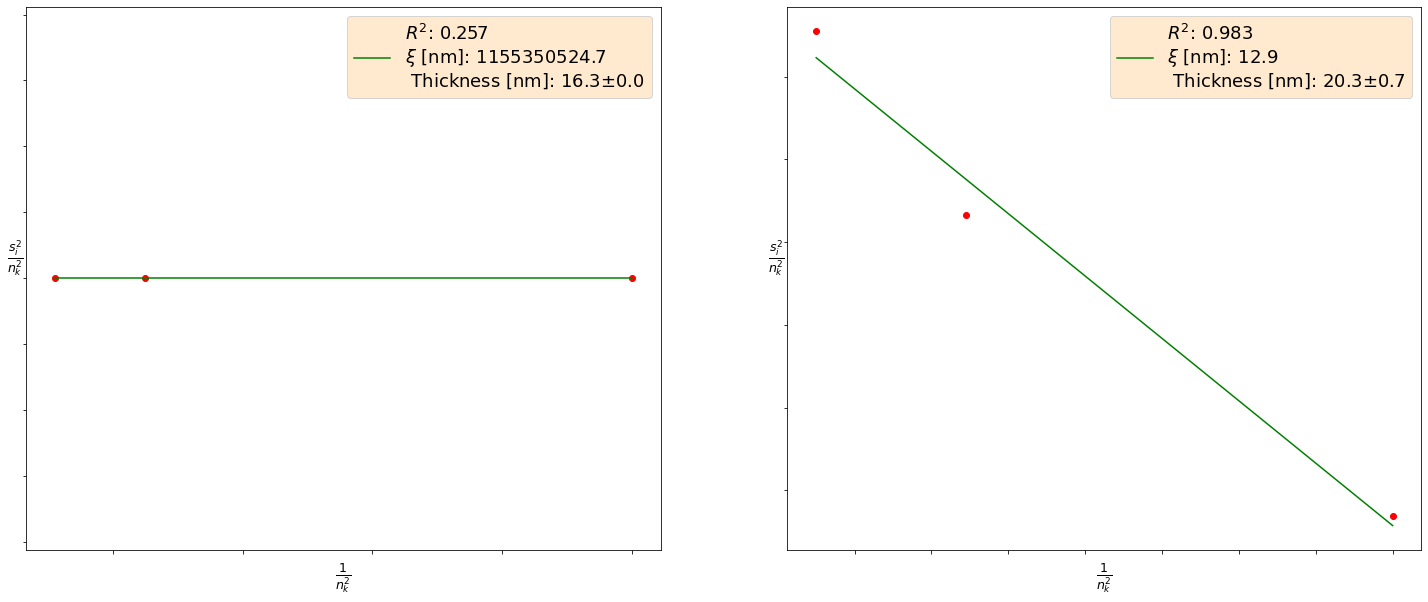

Experimental θ values are closest to the following thicknesses from simulation:34.425 nm,34.425 nm, 34.425 nm.


In [119]:
test.get_thickness_plot()
test.compare_with_simulation_220()

# Plans for next versions:

- Making the button work
- Writing output files
- Making the CBED-module as a package
- splitting the get_thickness_plot function into 3